<a href="https://colab.research.google.com/github/MarceloJoseVieira/notebooks-aprendizado-de-maquina-nao-supervisionado-1u/blob/main/Resolvido_Hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização Hierárquica

## 1. Introdução

Neste notebook, exploraremos os algoritmos de clusterização hierárquica, uma família de métodos que constrói uma hierarquia de clusters organizando os dados em uma estrutura semelhante a uma árvore. Diferentemente do K-Means, que requer que especifiquemos o número de clusters antecipadamente, a clusterização hierárquica nos permite descobrir a estrutura natural dos dados em diferentes níveis de granularidade.

A clusterização hierárquica pode ser dividida em duas abordagens principais:
- **Aglomerativa (Bottom-up)**: Inicia com cada ponto como um cluster individual e, iterativamente, combina os clusters mais próximos até formar um único cluster.
- **Divisiva (Top-down)**: Inicia com todos os pontos em um único cluster e, recursivamente, divide os clusters até que cada ponto forme seu próprio cluster.

### Conteúdos abordados:

* **Fundamentação Matemática**: Métricas de distância entre clusters e critérios de ligação.
* **Implementação em Python**: Construção do algoritmo aglomerativo passo a passo usando NumPy.
* **Dendrogramas**: Visualização da hierarquia de clusters.
* **Critérios de Ligação**: Single, Complete, Average e Ward.
* **Determinação do Número de Clusters**: Métodos para "cortar" o dendrograma.
* **Aplicações Práticas**: Análise de dados reais e comparação com K-Means.

In [2]:
# Célula de importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import seaborn as sns

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Fundamentação Matemática da Clusterização Hierárquica

A clusterização hierárquica aglomerativa funciona com base em uma **matriz de distâncias** entre todos os pares de pontos (ou clusters). O algoritmo segue estes passos fundamentais:

1. **Inicialização**: Cada observação $\mathbf{x}_i$ forma um cluster individual $C_i = \{\mathbf{x}_i\}$.

2. **Cálculo da Matriz de Distâncias**: Para $N$ pontos, calculamos uma matriz simétrica $D \in \mathbb{R}^{N \times N}$ onde $D_{ij}$ representa a distância entre os pontos $\mathbf{x}_i$ e $\mathbf{x}_j$:
   $$ D_{ij} = d(\mathbf{x}_i, \mathbf{x}_j) $$

3. **Iteração**: Em cada passo, encontramos o par de clusters $(C_i, C_j)$ com menor distância e os combinamos em um novo cluster $C_{ij} = C_i \cup C_j$.

4. **Atualização**: Recalculamos as distâncias do novo cluster para todos os outros clusters existentes.

5. **Terminação**: O processo continua até que reste apenas um cluster contendo todas as observações.

### Critérios de Ligação (Linkage)

O ponto crucial da clusterização hierárquica é como definimos a distância entre dois clusters. Existem vários critérios de ligação:

1. **Single Linkage (Ligação Simples)**:
   $$ d(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais próximos entre os clusters.

2. **Complete Linkage (Ligação Completa)**:
   $$ d(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais distantes entre os clusters.

3. **Average Linkage (Ligação Média)**:
   $$ d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é a média de todas as distâncias entre pares de pontos dos clusters.

4. **Ward Linkage (Critério de Ward)**:
   $$d(C_i, C_j) = \frac{|C_i||C_j|}{|C_i|+|C_j|} \|\mathbf{m}_i - \mathbf{m}_j\|^2$$
   Onde $\mathbf{m}_i$ e $\mathbf{m}_j$ são os centróides dos clusters $C_i$ e $C_j$, respectivamente, e $|C_k|$ é o número de pontos no cluster $C_k$.
   Minimiza a variância intra-cluster ao combinar clusters. É baseado na soma dos quadrados das distâncias aos centróides.

## 3. Preparação dos Dados

Vamos começar com um exemplo simples usando dados sintéticos para entender visualmente como funciona a clusterização hierárquica. Depois, aplicaremos o algoritmo ao dataset Iris.

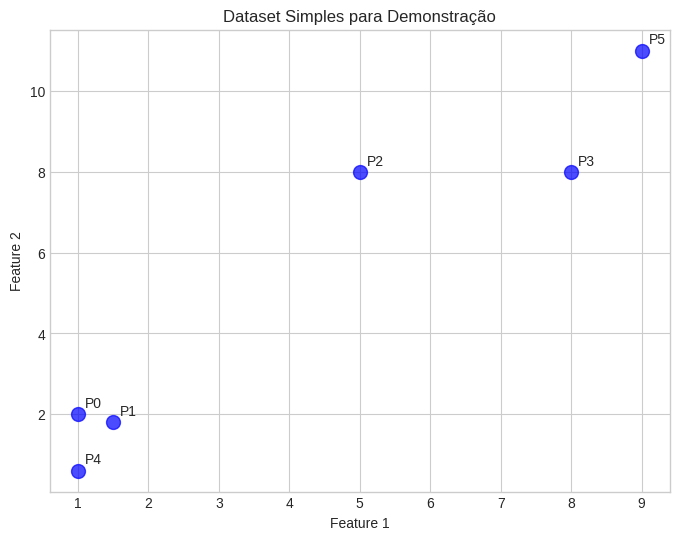

Coordenadas dos pontos:
P0: [1. 2.]
P1: [1.5 1.8]
P2: [5. 8.]
P3: [8. 8.]
P4: [1.  0.6]
P5: [ 9. 11.]


In [3]:
# Gerando dados sintéticos simples para demonstração
np.random.seed(42)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

# Visualizar os dados
plt.figure(figsize=(8, 6))
plt.scatter(X_simple[:, 0], X_simple[:, 1], c='blue', s=100, alpha=0.7)
for i, (x, y) in enumerate(X_simple):
    plt.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
plt.title('Dataset Simples para Demonstração')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

print(f"Coordenadas dos pontos:")
for i, point in enumerate(X_simple):
    print(f"P{i}: {point}")

## 4. Implementação do Algoritmo Hierárquico Aglomerativo

Vamos construir uma implementação simplificada do algoritmo hierárquico aglomerativo para entender seus passos fundamentais.

In [4]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.

        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []

    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist

        return dist_matrix

    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist

        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist

        elif self.linkage == 'average':
        # Distância média entre todos os pares de pontos dos clusters
            total_dist = 0.0
            numero_pares = 0
            for i in cluster1:
                for j in cluster2:
                    total_dist += dist_matrix[i, j]
                    numero_pares += 1
            return total_dist / numero_pares if numero_pares > 0 else 0


    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)

        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]

        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)

        self.merge_history = []
        self.distances = []

        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")

        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1

            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j

            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]

            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)

            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")

            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)

            print(f"Clusters restantes: {clusters}\n")

## 5. Executando o Algoritmo no Dataset Simples

Vamos aplicar nossa implementação nos dados simples para observar passo a passo como os clusters são formados.

In [5]:
# Executar a clusterização hierárquica com ligação simples
hc_single = HierarchicalClustering(linkage='single')
hc_single.fit(X_simple)

Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.300
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Combinar clusters [5] e [2, 3]
Distância: 3.162
Clusters restantes: [[4, 0, 1], [5, 2, 3]]

Passo 5: Combinar clusters [4, 0, 1] e [5, 2, 3]
Distância: 7.120
Clusters restantes: [[4, 0, 1, 5, 2, 3]]



## 6. Dendrogramas: Visualizando a Hierarquia

Um **dendrograma** é a representação gráfica da hierarquia de clusters. É uma estrutura em forma de árvore que mostra a ordem e as distâncias nas quais os clusters foram combinados.

### Interpretação do Dendrograma:
- **Eixo horizontal**: Representa as observações ou clusters.
- **Eixo vertical**: Representa a distância na qual os clusters foram unidos.
- **Altura dos ramos**: Indica a dissimilaridade entre os clusters combinados.

Vamos usar a implementação otimizada do SciPy para criar dendrogramas profissionais:

### Usando as Funções `linkage` e `fcluster` do SciPy

O SciPy fornece funções otimizadas para clusterização hierárquica que são muito mais eficientes que nossa implementação educacional. As duas funções principais são:

#### 1. Função `linkage(X, method)`

A função `linkage` calcula a matriz de ligação que representa a hierarquia de clusters:

```python
from scipy.cluster.hierarchy import linkage

# Sintaxe básica
linkage_matrix = linkage(X, method='ward')
```

**Parâmetros principais:**
- `X`: matriz de dados (n_samples × n_features)
- `method`: critério de ligação ('single', 'complete', 'average', 'ward')
- `metric`: métrica de distância (padrão: 'euclidean')

**Retorno:**
- Matriz (n-1) × 4 onde cada linha representa uma fusão:
  - Colunas 0 e 1: índices dos clusters sendo combinados
  - Coluna 2: distância da fusão
  - Coluna 3: número de observações no novo cluster

#### 2. Função `fcluster(Z, t, criterion)`

A função `fcluster` extrai clusters da matriz de ligação com base em um critério de corte:

```python
from scipy.cluster.hierarchy import fcluster

# Obter clusters com base na distância
clusters = fcluster(linkage_matrix, t=3.0, criterion='distance')

# Obter um número específico de clusters
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
```

**Parâmetros principais:**
- `Z`: matriz de ligação (resultado de `linkage`)
- `t`: valor do critério de corte
- `criterion`: tipo de critério ('distance', 'maxclust', 'inconsistent')

**Critérios de corte:**
- `'distance'`: corta em uma altura específica do dendrograma
- `'maxclust'`: força um número específico de clusters
- `'inconsistent'`: baseado no coeficiente de inconsistência

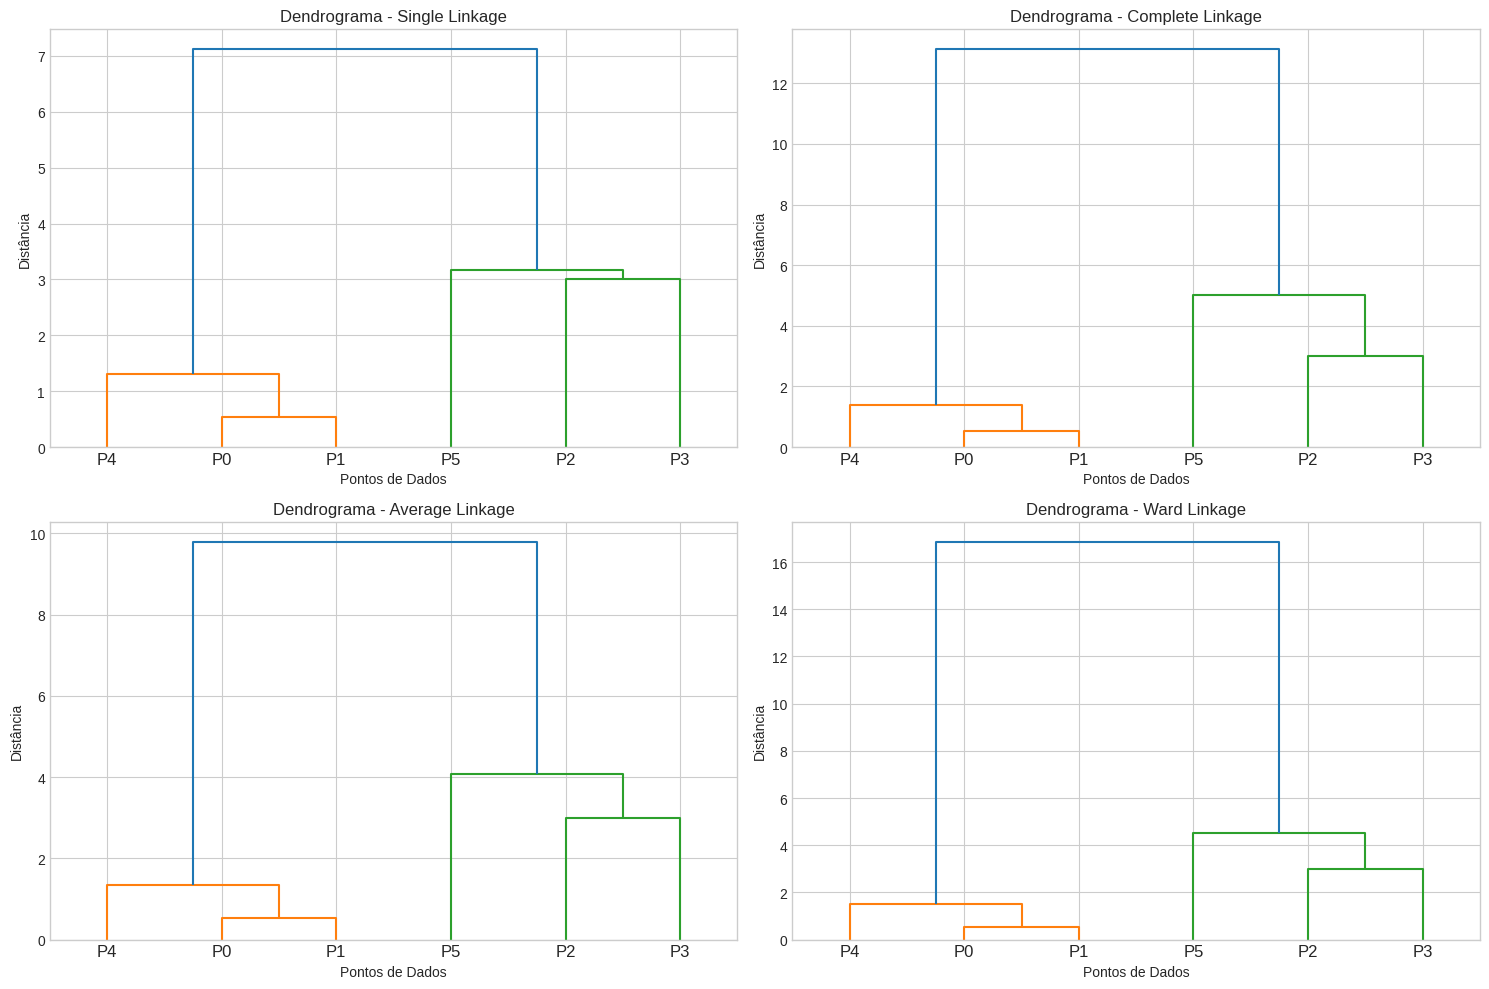

In [6]:
# Usando scipy para criar dendrogramas profissionais
# Diferentes critérios de ligação

linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_simple, method=method)

    # Criar o dendrograma
    dendrogram(linkage_matrix, ax=axes[i], labels=[f'P{j}' for j in range(len(X_simple))])
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Pontos de Dados')
    axes[i].set_ylabel('Distância')

plt.tight_layout()
plt.show()

### Comparação dos Critérios de Ligação

Cada critério de ligação produz diferentes estruturas de cluster:

- **Single Linkage**: Tende a criar clusters elongados e pode sofrer do "efeito corrente" (chaining effect).
- **Complete Linkage**: Produz clusters mais compactos e esféricos.
- **Average Linkage**: Um meio-termo entre single e complete.
- **Ward Linkage**: Minimiza a variância intra-cluster, similar ao objetivo do K-Means.

## 7. Determinando o Número de Clusters

Uma das grandes vantagens da clusterização hierárquica é que podemos "cortar" o dendrograma em diferentes alturas para obter diferentes números de clusters. Isso é feito traçando uma linha horizontal através do dendrograma.

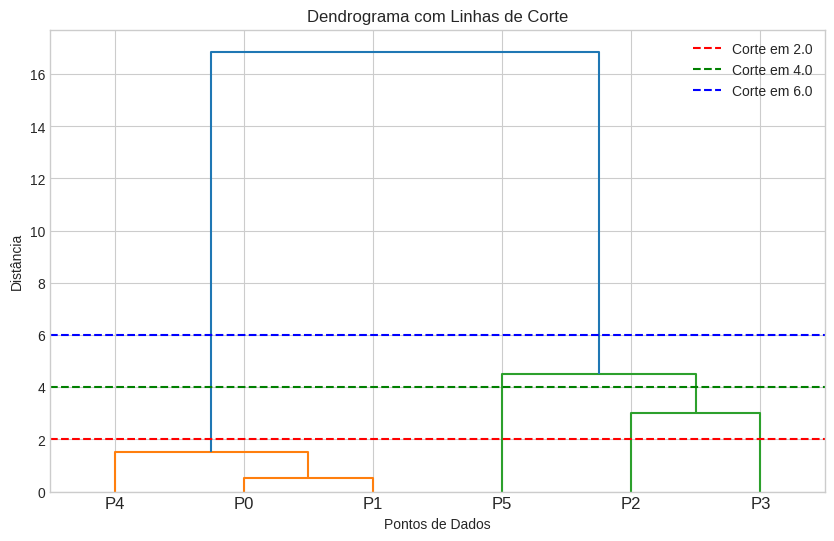

In [7]:
# Usar Ward linkage para o exemplo
linkage_matrix = linkage(X_simple, method='ward')

# Definir diferentes alturas de corte
cut_heights = [2.0, 4.0, 6.0]
colors = ['red', 'green', 'blue']

# Visualizar o dendrograma com diferentes cortes
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=[f'P{j}' for j in range(len(X_simple))])

for height, color in zip(cut_heights, colors):
    plt.axhline(y=height, color=color, linestyle='--', label=f'Corte em {height}')

plt.title('Dendrograma com Linhas de Corte')
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância')
plt.legend()
plt.show()

In [8]:
# Predição de clusters baseada em diferentes linhas de corte
from scipy.cluster.hierarchy import fcluster

print("Predição de clusters para diferentes alturas de corte:")
print("=" * 55)

for i, height in enumerate(cut_heights):
    # Obter clusters para a altura de corte específica
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    n_clusters = len(np.unique(clusters))

    print()
    print(f"Altura de corte: {height}")
    print(f"Número de clusters: {n_clusters}")

    # Mostrar quais pontos pertencem a cada cluster
    for cluster_id in np.unique(clusters):
        points = [f"P{j}" for j in range(len(X_simple)) if clusters[j] == cluster_id]
        print(f"  Cluster {cluster_id}: {points}")

Predição de clusters para diferentes alturas de corte:

Altura de corte: 2.0
Número de clusters: 4
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2']
  Cluster 3: ['P3']
  Cluster 4: ['P5']

Altura de corte: 4.0
Número de clusters: 3
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2', 'P3']
  Cluster 3: ['P5']

Altura de corte: 6.0
Número de clusters: 2
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2', 'P3', 'P5']


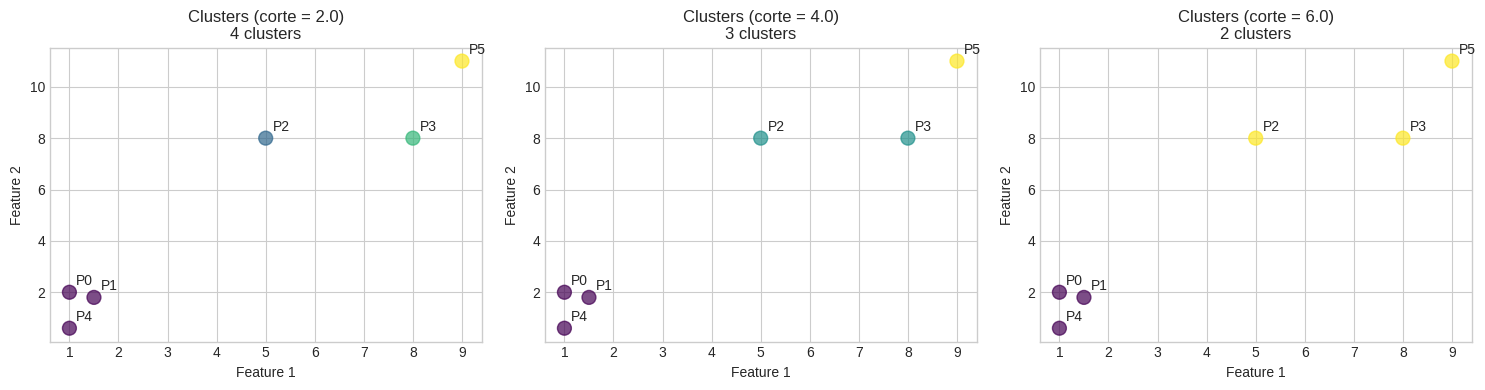

In [9]:
# Visualização dos clusters resultantes
fig, axes = plt.subplots(1, len(cut_heights), figsize=(15, 4))

for i, height in enumerate(cut_heights):
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    scatter = axes[i].scatter(X_simple[:, 0], X_simple[:, 1], c=clusters, s=100, alpha=0.7, cmap='viridis')

    # Adicionar rótulos dos pontos
    for j, (x, y) in enumerate(X_simple):
        axes[i].annotate(f'P{j}', (x, y), xytext=(5, 5), textcoords='offset points')

    axes[i].set_title(f'Clusters (corte = {height})\n{len(np.unique(clusters))} clusters')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## 8. Aplicação ao Dataset Iris

Agora vamos aplicar a clusterização hierárquica ao dataset Iris e comparar os resultados com o K-Means.

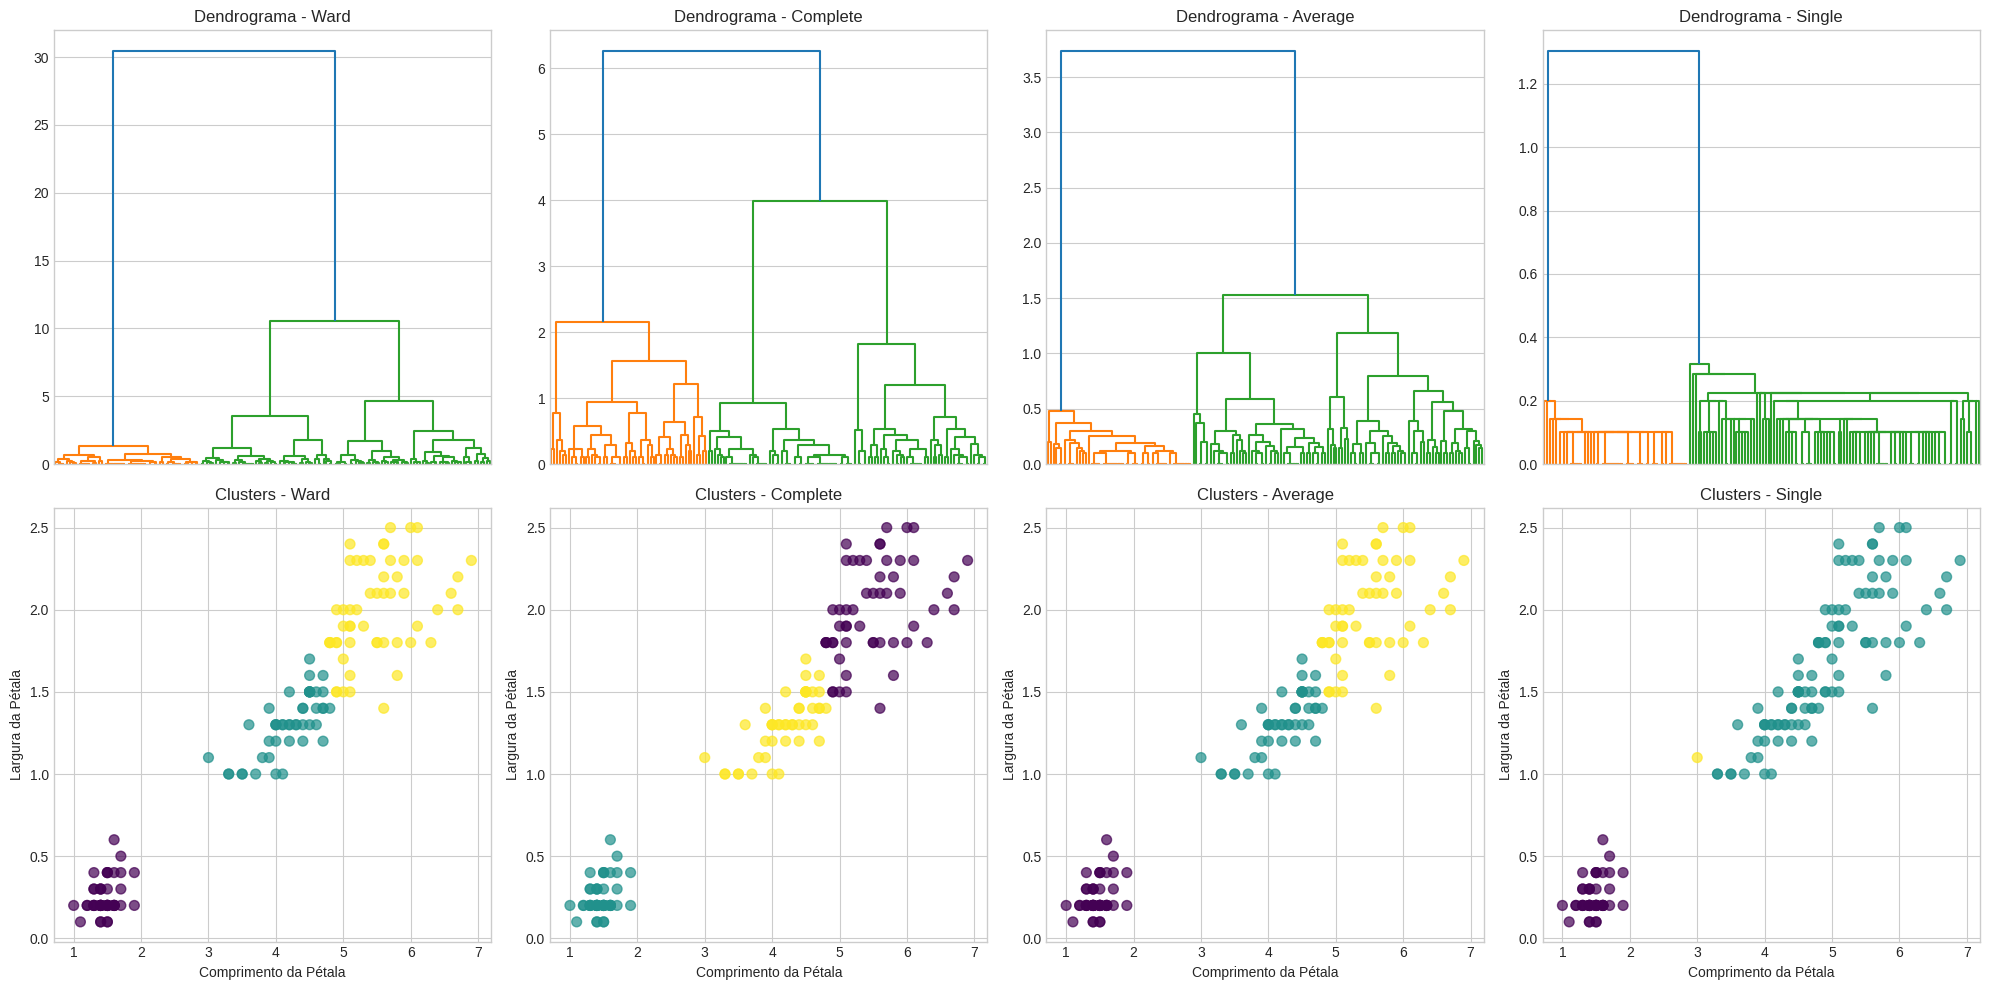

In [10]:
# Carregar o dataset Iris
iris = load_iris()
X_iris = iris.data[:, 2:]  # Usar comprimento e largura da pétala
y_true = iris.target

# Aplicar diferentes métodos de ligação
methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, method in enumerate(methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_iris, method=method)

    # Dendrograma
    dendrogram(linkage_matrix, ax=axes[0, i], no_labels=True)
    axes[0, i].set_title(f'Dendrograma - {method.capitalize()}')

    # Obter 3 clusters
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

    # Plotar os clusters
    scatter = axes[1, i].scatter(X_iris[:, 0], X_iris[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[1, i].set_title(f'Clusters - {method.capitalize()}')
    axes[1, i].set_xlabel('Comprimento da Pétala')
    axes[1, i].set_ylabel('Largura da Pétala')

plt.tight_layout()
plt.show()

### Avaliação dos Resultados

Vamos calcular a taxa de acertos para cada método de ligação:

In [11]:
from scipy.stats import mode

def calculate_purity(y_true, y_pred):
    """
    Calcula a pureza dos clusters comparando com os rótulos verdadeiros.
    """
    correct_predictions = 0
    n_samples = len(y_true)

    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)

    return correct_predictions / n_samples

print("Comparação dos métodos de ligação no dataset Iris:")
print("="*50)

for method in methods:
    linkage_matrix = linkage(X_iris, method=method)
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    purity = calculate_purity(y_true, clusters)
    print(f"{method.capitalize():12} Linkage: {purity:.1%} de acertos")

Comparação dos métodos de ligação no dataset Iris:
Ward         Linkage: 96.0% de acertos
Complete     Linkage: 96.0% de acertos
Average      Linkage: 96.0% de acertos
Single       Linkage: 67.3% de acertos


### Exercício 1: Implementação do Average Linkage

Complete a implementação da nossa classe `HierarchicalClustering` adicionando o método **Average Linkage**. Em seguida, teste todos os três métodos de ligação (single, complete, average) no dataset simples (`X_simple`) e compare os resultados.

In [12]:
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

hc_single = HierarchicalClustering(linkage='single')
hc_single.fit(X_simple)

hc_complete = HierarchicalClustering(linkage='complete')
hc_complete.fit(X_simple)

hc_avarege = HierarchicalClustering(linkage='average')
hc_avarege.fit(X_simple)

Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.300
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Combinar clusters [5] e [2, 3]
Distância: 3.162
Clusters restantes: [[4, 0, 1], [5, 2, 3]]

Passo 5: Combinar clusters [4, 0, 1] e [5, 2, 3]
Distância: 7.120
Clusters restantes: [[4, 0, 1, 5, 2, 3]]

Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.400
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Comb

### Exercício 2: Análise do Dataset Wine - Seleção de Features e Comparação de Métodos

Aplique a clusterização hierárquica do SciPy ao dataset Wine. Primeiro, você deve selecionar um bom par de features para visualização bidimensional, depois comparar diferentes métodos de ligação.

**Tarefas:**
1. Carregue o dataset Wine e explore suas features
2. Selecione as duas melhores features para visualização (analise correlações, variâncias, etc.)
3. Aplique os 4 métodos de ligação ('single', 'complete', 'average', 'ward') usando `scipy.cluster.hierarchy.linkage`
4. Crie dendrogramas para cada método
5. Determine visualmente qual método produz a melhor separação

Dataset Wine:
Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']


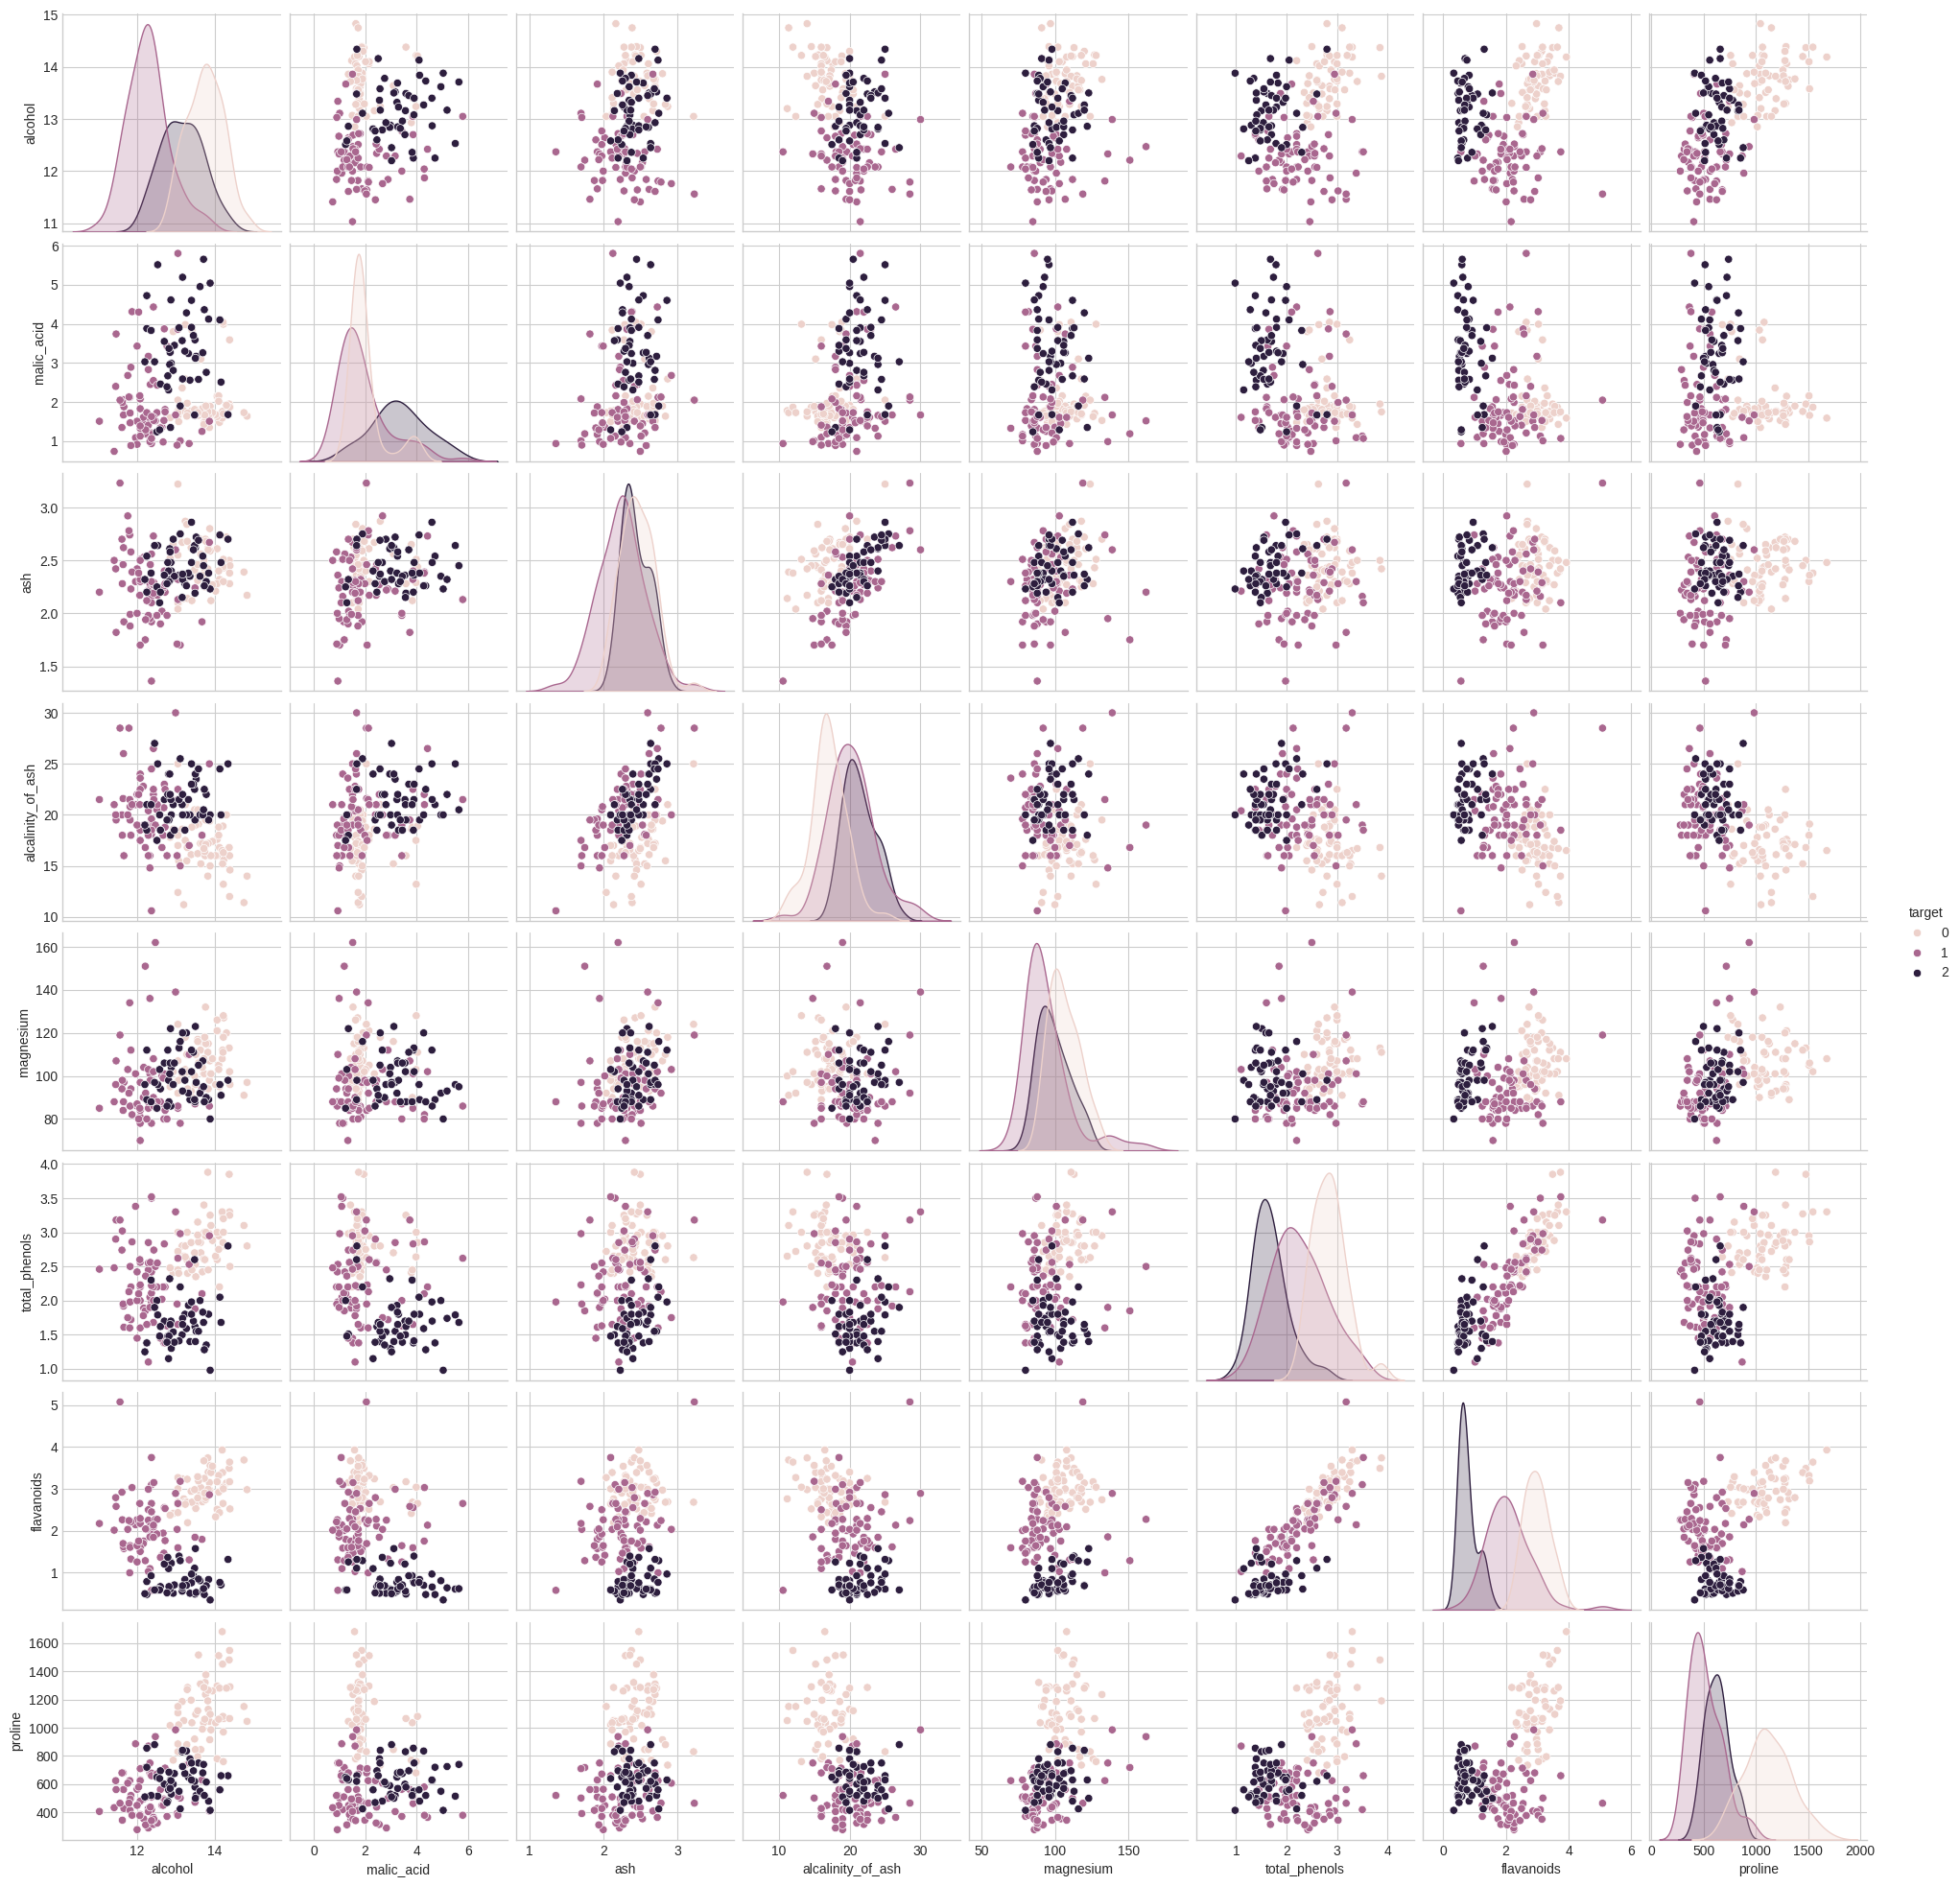

Features selecionadas para o dataset Wine: 'flavanoids' e 'proline'



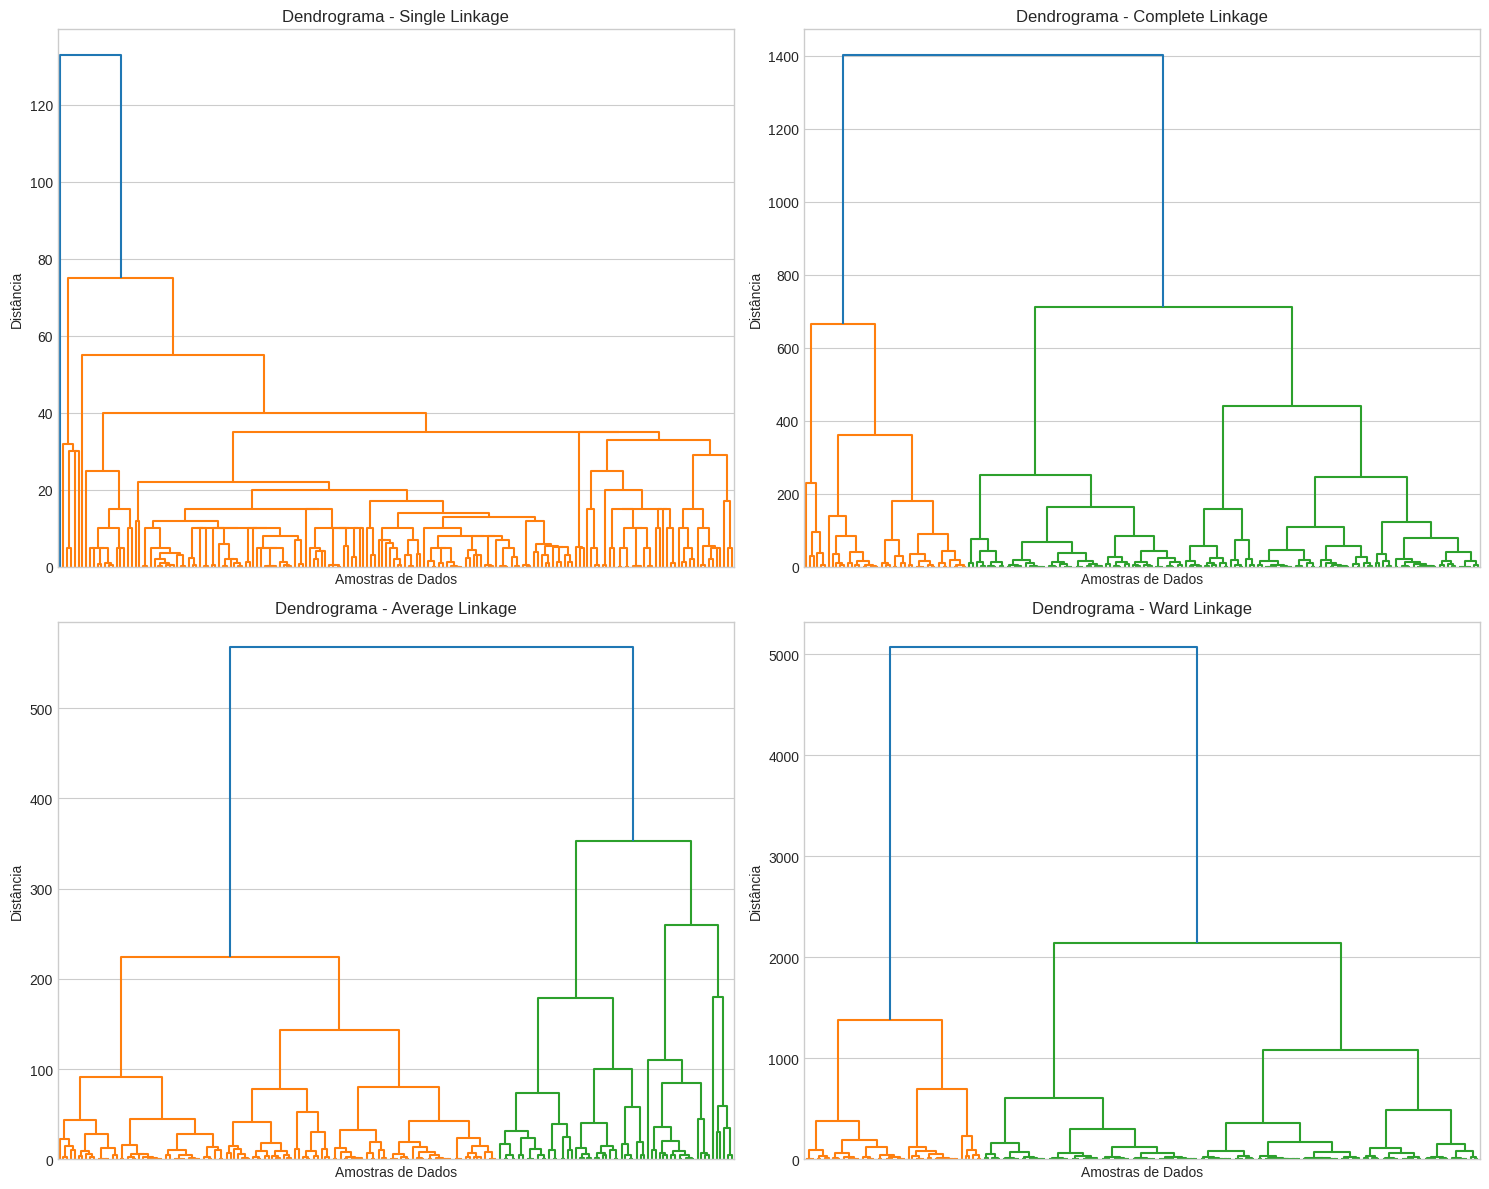


COMPARANDO OS MÉTODOS:
Ward tende a formar clusters mais equilibrados.
Single pode gerar o problema do "encadeamento" (clusters muito alongados).
Complete e Average ficam no meio-termo.



In [13]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Shape: {X_wine.shape}")
print(f"Features: {wine.feature_names}")
print(f"Classes: {wine.target_names}")

wine_df = pd.DataFrame(X_wine, columns=wine.feature_names)
wine_df['target'] = y_wine

# 2. Análise das features para seleção
sns.pairplot(wine_df, hue='target', vars=['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'proline'])
plt.show()

# 3. Seleção das duas melhores features
feature1 = 'flavanoids'
feature2 = 'proline'
X_wine_selected = wine_df[[feature1, feature2]].values
print(f"Features selecionadas para o dataset Wine: '{feature1}' e '{feature2}'\n")

# 4. Aplicação dos métodos de ligação e criação dos dendrogramas
linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    linkage_matrix = linkage(X_wine_selected, method=method)

    dendrogram(linkage_matrix, ax=axes[i])
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Amostras de Dados')
    axes[i].set_ylabel('Distância')
    axes[i].set_xticks([])

plt.tight_layout()
plt.show()

# 5. Análise visual e determinação do melhor método
print("""
COMPARANDO OS MÉTODOS:
Ward tende a formar clusters mais equilibrados.
Single pode gerar o problema do "encadeamento" (clusters muito alongados).
Complete e Average ficam no meio-termo.
""")

### Exercício 3: Determinação do Número Ótimo de Clusters

Com base no melhor método de ligação identificado no Exercício 2, determine o número ótimo de clusters para o dataset Wine usando análise visual do dendrograma e validação com os rótulos verdadeiros.

**Tarefas:**
1. Use o melhor método identificado no exercício anterior
2. Crie um dendrograma detalhado com linha de corte ajustável
3. Teste diferentes números de clusters (2, 3, 4, 5) usando `fcluster`
4. Para cada número de clusters, visualize os clusters no scatter plot
5. Determine o número ótimo de clusters justificando sua escolha

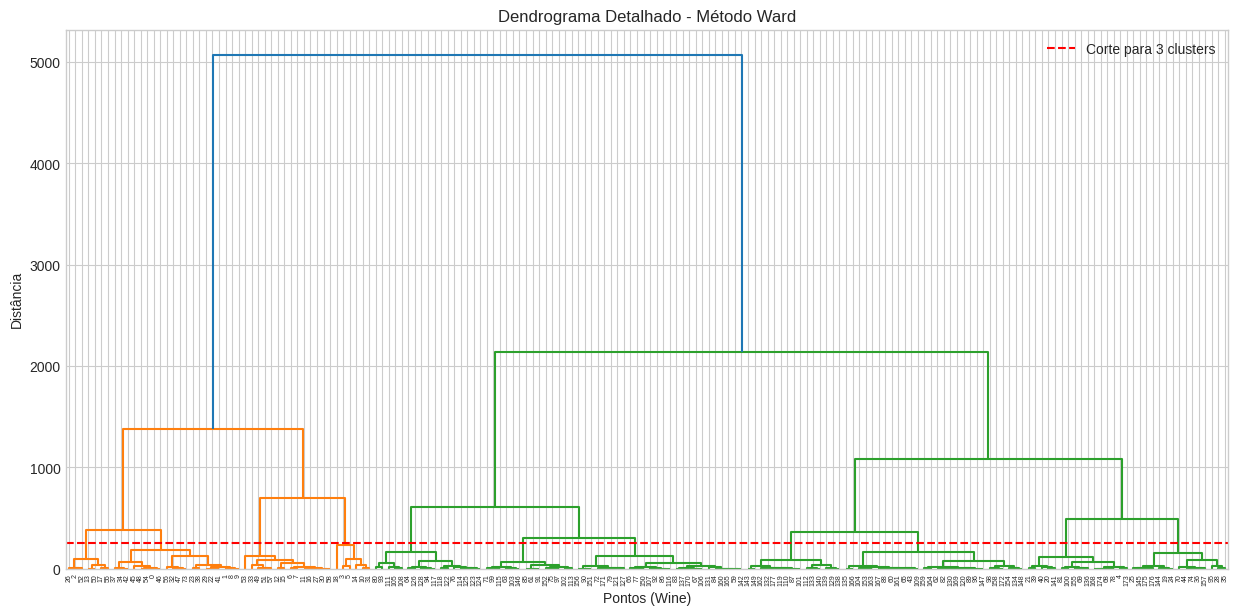

Análise do número ótimo de clusters:


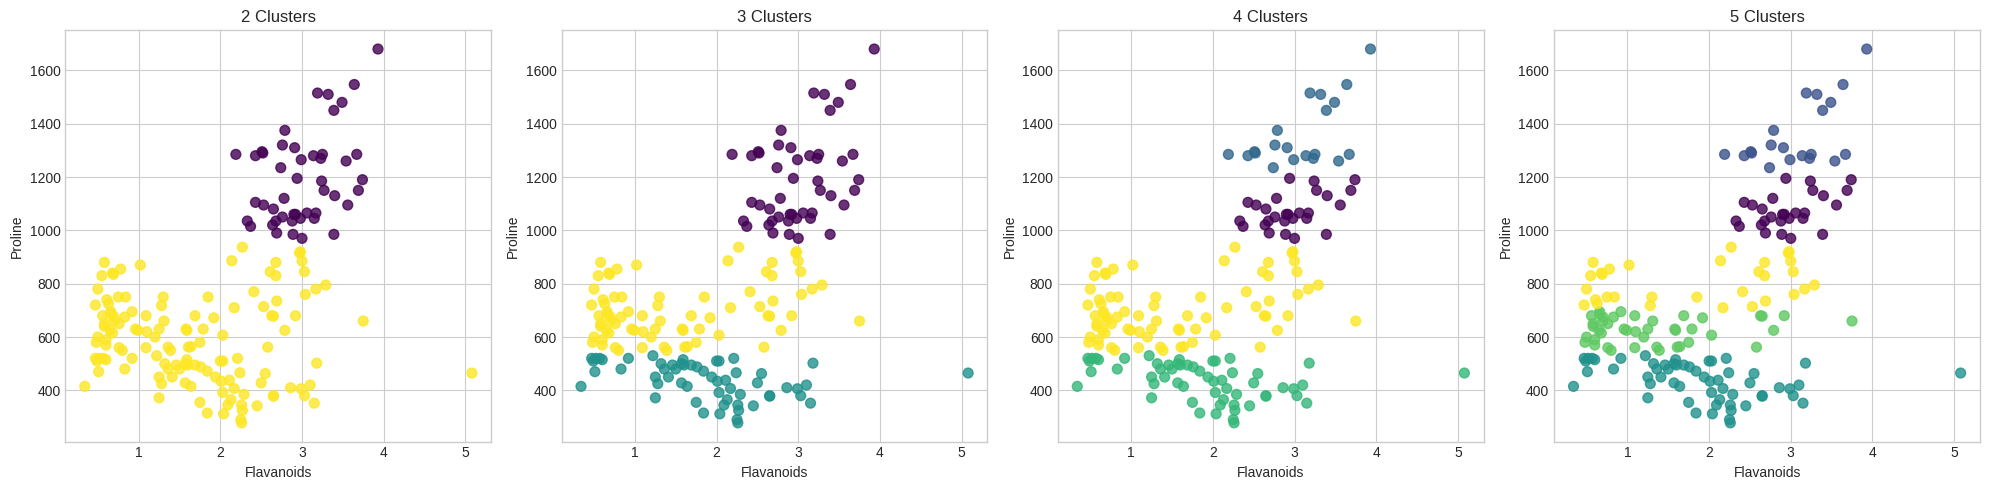


Justificativa para o Número Ótimo de Clusters:

O número ótimo de clusters para o dataset Wine, usando o método de Ward, é 3.

1.  Análise do Dendrograma: A linha de corte horizontal em y=250 (ou qualquer valor entre 150 e 350) cruza exatamente três linhas verticais longas, indicando que a estrutura mais natural dos dados se divide em três grandes grupos antes que eles sejam subdivididos em clusters menores e menos distintos.
2.  Análise Visual: A visualização dos scatter plots mostra que com k=3, os clusters são bem definidos e correspondem a agrupamentos visualmente coesos dos dados. Com k=2, clusters claramente distintos são forçados a se unir. Com k=4 ou k=5, clusters que parecem ser um único grupo são divididos de forma aparentemente arbitrária.
3.  Conhecimento do Domínio: Sabemos que o dataset Wine possui 3 classes de vinhos, e a clusterização com k=3 recupera essa estrutura com sucesso.



In [14]:
from re import X
# Exercício 3: Determinação do Número Ótimo de Clusters

# 1. Use o melhor método do exercício anterior
best_method = 'ward'
X_wine_selected = wine_df[[feature1, feature2]].values

linkage_matrix_ward = linkage(X_wine_selected, method=best_method)

# 2. Crie dendrograma com diferentes linhas de corte
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix_ward)
plt.title(f'Dendrograma Detalhado - Método {best_method.capitalize()}')
plt.xlabel('Pontos (Wine)')
plt.ylabel('Distância')

plt.axhline(y=250, color='r', linestyle='--', label='Corte para 3 clusters')
plt.legend()
plt.show()

# 3. Teste diferentes números de clusters
n_clusters_to_test = [2, 3, 4, 5]

print("Análise do número ótimo de clusters:")
print("=" * 40)

fig, axes = plt.subplots(1, len(n_clusters_to_test), figsize=(20, 5))

for i, n_clusters in enumerate(n_clusters_to_test):
    clusters = fcluster(linkage_matrix_ward, t=n_clusters, criterion='maxclust')

    axes[i].scatter(X_wine_selected[:, 0], X_wine_selected[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
    axes[i].set_title(f'{n_clusters} Clusters')
    axes[i].set_xlabel('Flavanoids')
    axes[i].set_ylabel('Proline')

plt.tight_layout()
plt.show()

print("""
Justificativa para o Número Ótimo de Clusters:

O número ótimo de clusters para o dataset Wine, usando o método de Ward, é 3.

1.  Análise do Dendrograma: A linha de corte horizontal em y=250 (ou qualquer valor entre 150 e 350) cruza exatamente três linhas verticais longas, indicando que a estrutura mais natural dos dados se divide em três grandes grupos antes que eles sejam subdivididos em clusters menores e menos distintos.
2.  Análise Visual: A visualização dos scatter plots mostra que com k=3, os clusters são bem definidos e correspondem a agrupamentos visualmente coesos dos dados. Com k=2, clusters claramente distintos são forçados a se unir. Com k=4 ou k=5, clusters que parecem ser um único grupo são divididos de forma aparentemente arbitrária.
3.  Conhecimento do Domínio: Sabemos que o dataset Wine possui 3 classes de vinhos, e a clusterização com k=3 recupera essa estrutura com sucesso.
""")
